## Exploring Meta Stock Data (2014-2023): Predicting Closing Prices

This project delves into the world of Meta stock data, specifically focusing on the period from 2014 to 2023. Our goal is to gain valuable insights into the factors influencing the stock's price movements. 

By employing exploratory data analysis (EDA), we'll embark on a journey to uncover hidden patterns and relationships within the data. We'll delve into the data's distribution, central tendencies, and potential outliers, seeking to understand the overall characteristics of the stock's price movements over the past decade.

Furthermore, we'll leverage the power of regression analysis to identify the variables that exert the most significant influence on the next day's closing price. This analysis will provide a quantitative understanding of how different factors contribute to the stock's price fluctuations, potentially aiding in informed decision-making.

Throughout this project, we'll not only uncover these key factors but also interpret and visualize the results, offering a comprehensive understanding of the relationship between various variables and the next day's closing price for Meta stock.


This project utilizes a comprehensive dataset encompassing Meta's stock information for the past decade (2014-2023). https://www.kaggle.com/datasets/aspillai/meta-stock-price-technical-indicators-10-years?resource=download This rich data provides insights into various aspects of the stock's performance and allows us to explore the factors influencing its price movements.

Here's a breakdown of the key features within the dataset:

* **Standard Price Data:** Open, High, Low, and Close prices offer a foundational understanding of the stock's intraday and closing price movements.
* **Volume:** This metric captures the number of shares traded on a specific day, indicating trading activity and potential market sentiment.
* **Technical Indicators:**
    * **RSI (7 & 14 days):** This momentum indicator signals potential overbought or oversold conditions based on recent price changes.
    * **CCI (7 & 14 days):** This indicator helps analyze the difference between the current price and the historical average price, providing insights into short-term (7-day) and medium-term (14-day) trends.
    * **Moving Averages (SMA & EMA - 50 & 100 days):** These indicators smooth out price fluctuations and highlight potential support and resistance levels.
    * **MACD:** This indicator measures the relationship between two moving averages, offering insights into potential trend strength and reversals.
    * **Bollinger Bands:** These bands track price volatility, with the stock price typically fluctuating within the upper and lower bands.
    * **ATR (7 & 14 days):** This measure of volatility helps us understand the average price range over a specific timeframe (7 or 14 days).
* **Target Variable:** The "Next_Day_Close" price serves as the target variable for our analysis, allowing us to explore the relationship between various factors and the subsequent day's closing price.

By leveraging this comprehensive dataset, we aim to uncover valuable insights into the factors driving Meta's stock price fluctuations and potentially build models for future price prediction, keeping in mind that past performance is not indicative of future results.


In [11]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML


# Load data (replace "meta_data.csv" with your actual file path)
data = pd.read_csv("meta_2014_2023.csv")

data.head()

#data.info()

# Set date as the index
data.set_index("date", inplace=True)


### Time Series of Closing Price
Lets take a look at the time series data of Meta's closing stock price for the past 10 years. We see a general increase throughout and more drastic increases post 2019 but also see a massive drop off after 2021 after which the price seems to be in recovery of its pre 2021 heights. 

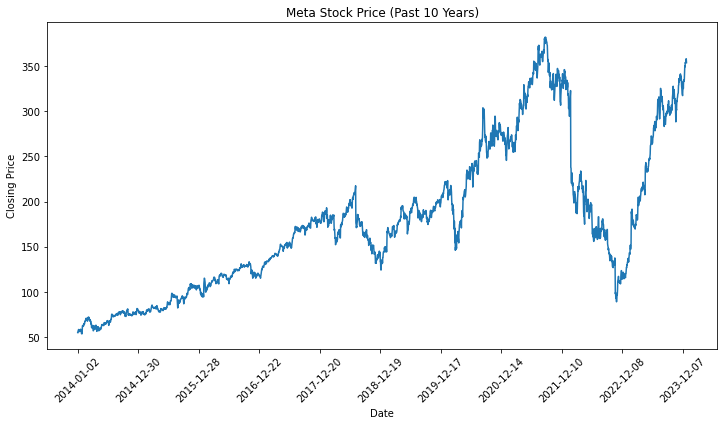

In [8]:
# Data exploration and cleaning (check for missing values, outliers, etc.)
#print(data.describe())  # View summary statistics
#print(data.isnull().sum())  # Check for missing values

# Focus on relevant columns for analysis
relevant_data = data[["open", "high", "low", "close", "volume", "rsi_7", "rsi_14", "cci_7", "cci_14"]]

# Calculate returns
data["Returns"] = data["close"].pct_change() * 100


# Visualize price movements (time series)
plt.figure(figsize=(12, 6))
plt.plot(data["close"])
plt.xticks(rotation=45)
plt.title("Meta Stock Price (Past 10 Years)")
plt.xlabel("Date")
plt.ylabel("Closing Price")

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))  # Set 10 ticks

plt.show()



### Price Change Distibution and Volume Distribution
Lets look at the distribution of the price changes in a day which is calculated by finding the difference between the close price for a given day and the open price for that day. 
We can also see the volume distribution.

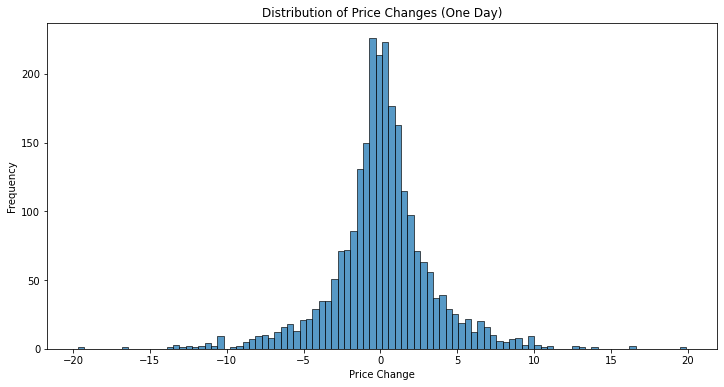

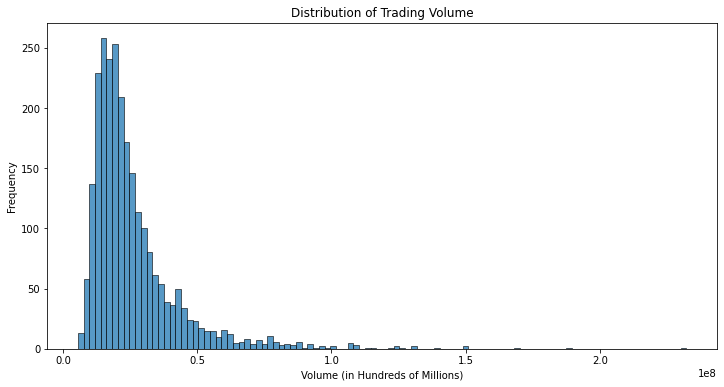

In [14]:
data["price_change"] = data["close"] - data["open"]

# Visualize volume distribution (histogram)
plt.figure(figsize=(12, 6))
sns.histplot(data["price_change"])
plt.title("Distribution of Price Changes (One Day)")
plt.xlabel("Price Change")
plt.ylabel("Frequency")
plt.show()

# Visualize volume distribution (histogram)
plt.figure(figsize=(12, 6))
sns.histplot(data["volume"])
plt.title("Distribution of Trading Volume")
plt.xlabel("Volume (in Hundreds of Millions)")
plt.ylabel("Frequency")
plt.show()

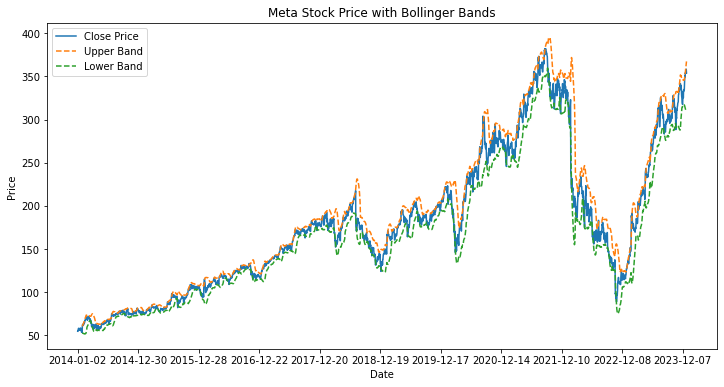

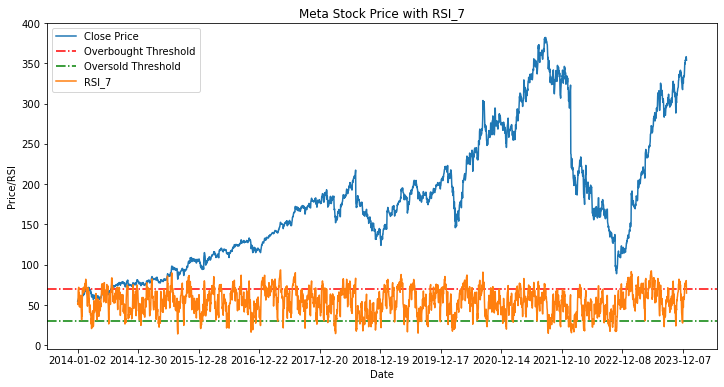

In [4]:
# Analyze and visualize technical indicators (e.g., RSI, CCI, Bollinger Bands)

# Analyze and visualize technical indicators

# Calculate Bollinger Bands (assuming 20-day window and 2 standard deviations)
data["Upper_Band"] = data["close"].rolling(window=20).mean() + 2 * data["close"].rolling(window=20).std()
data["Lower_Band"] = data["close"].rolling(window=20).mean() - 2 * data["close"].rolling(window=20).std()

# Plot Bollinger Bands with price
plt.figure(figsize=(12, 6))
plt.plot(data["close"], label="Close Price")
plt.plot(data["Upper_Band"], label="Upper Band", linestyle="--")
plt.plot(data["Lower_Band"], label="Lower Band", linestyle="--")
plt.title("Meta Stock Price with Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))  # Set 12 ticks

plt.show()

# Analyze and visualize RSI
plt.figure(figsize=(12, 6))
plt.plot(data["close"], label="Close Price")
plt.axhline(y=70, color="red", linestyle="-.", label="Overbought Threshold")
plt.axhline(y=30, color="green", linestyle="-.", label="Oversold Threshold")
plt.plot(data["rsi_7"], label="RSI_7")
plt.title("Meta Stock Price with RSI_7")
plt.xlabel("Date")
plt.ylabel("Price/RSI")
plt.legend()
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))  # Set 12 ticks

plt.show()


### Lets analyze the relationship between various features and the target variable "Next_Day_Close":

**1. Correlation Matrix:**

* This visualization will be a **heatmap** showcasing the **correlation coefficients** between the selected columns ("close", "open", "volume", "rsi_14", "atr_14", "next_day_close", and "price_change").
* The heatmap uses color intensity to represent the strength and direction of the correlation. A positive correlation is indicated by a **red color**, while a negative correlation is indicated by a **blue color**. The closer the color intensity to red or blue, the stronger the correlation.
* This matrix helps **identify potential relationships** between the chosen features and the target variable, providing insights into which features might have a stronger influence on the next day's closing price.

**2. Scatter Plots:**

* This section will create individual **scatter plots** for each chosen feature ("close", "open", "volume", "rsi_14", "atr_14", and "price_change") against the target variable ("Next_Day_Close").
* Each scatter plot will display the **distribution of data points** and visually represent the **relationship** between the chosen feature and the next day's closing price.
* By observing the scatter plots, you can potentially identify **trends** or **patterns** in the data, such as linear relationships, non-linear relationships, or clusters of data points.

A positive correlation between "atr_14" and "next_day_close" implies that higher average true range (volatility) tends to be accompanied by higher next day's closing price, and vice versa. However, it's crucial to remember that correlation doesn't necessarily imply causation.

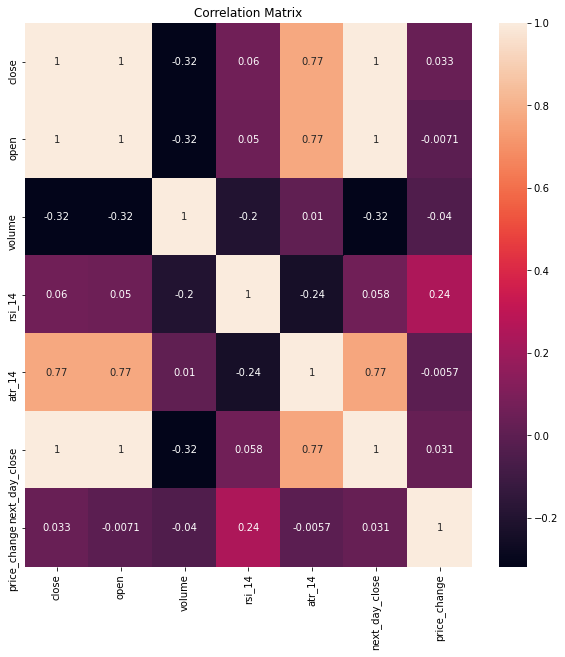

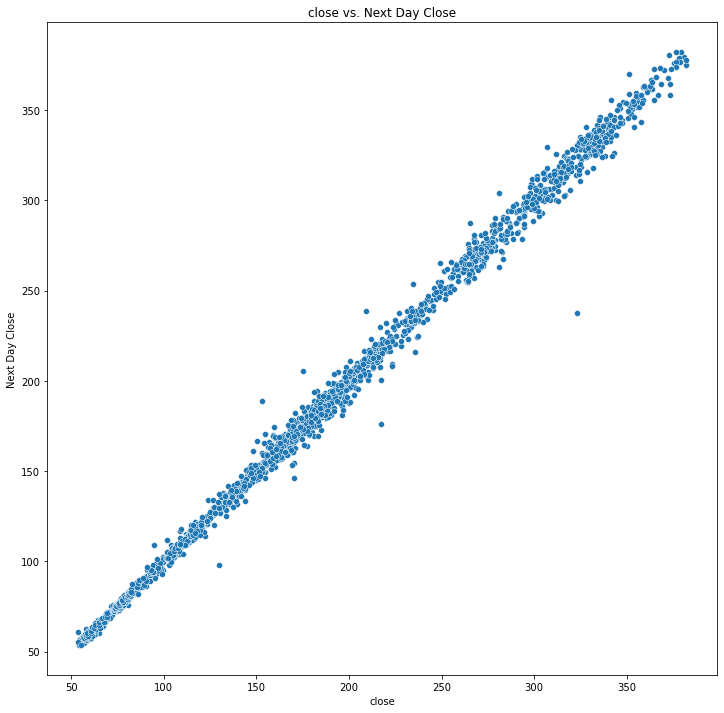

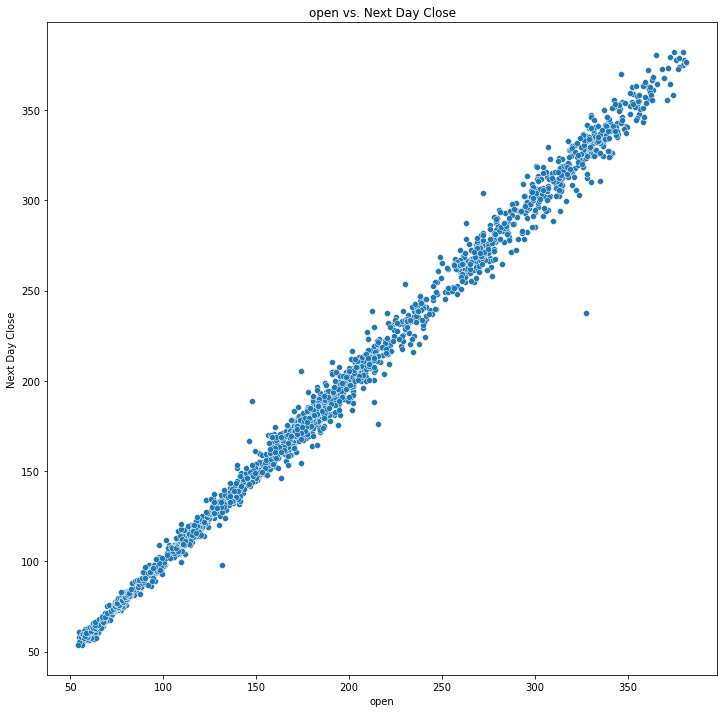

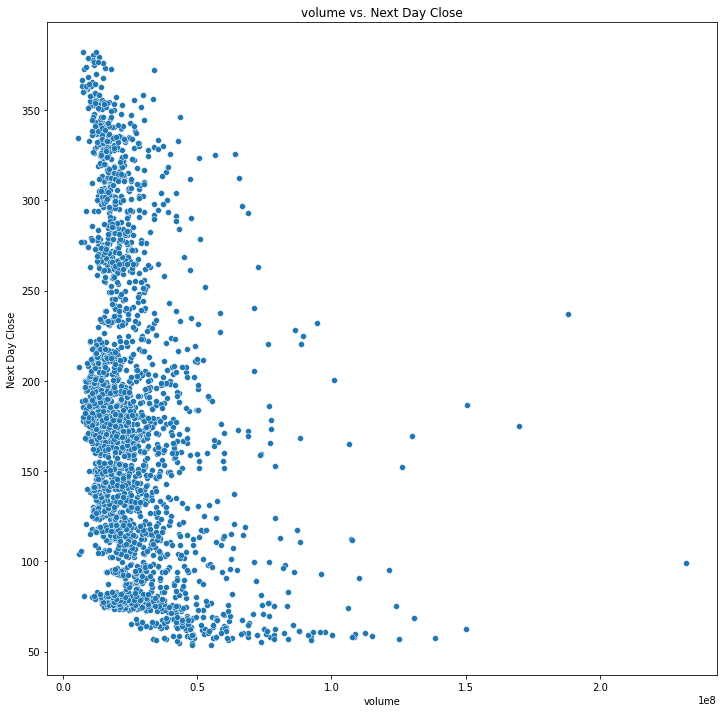

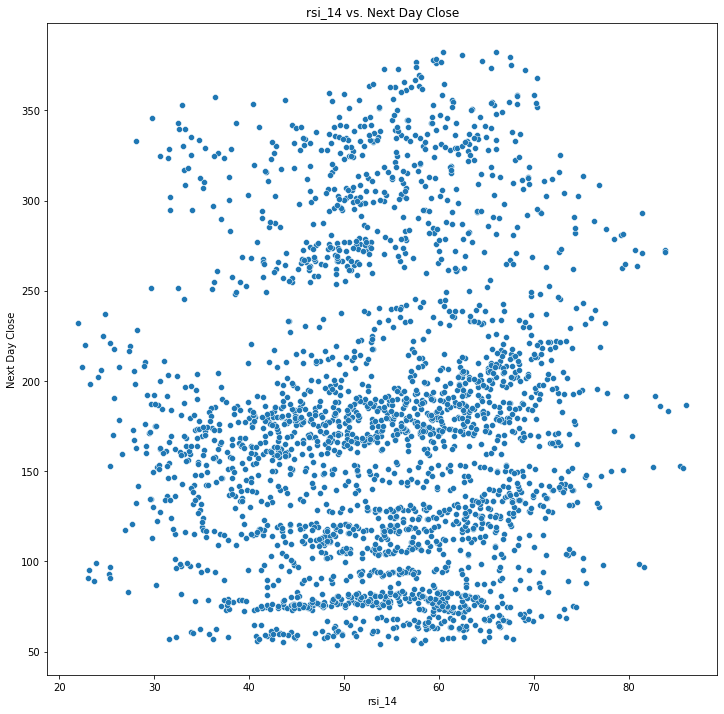

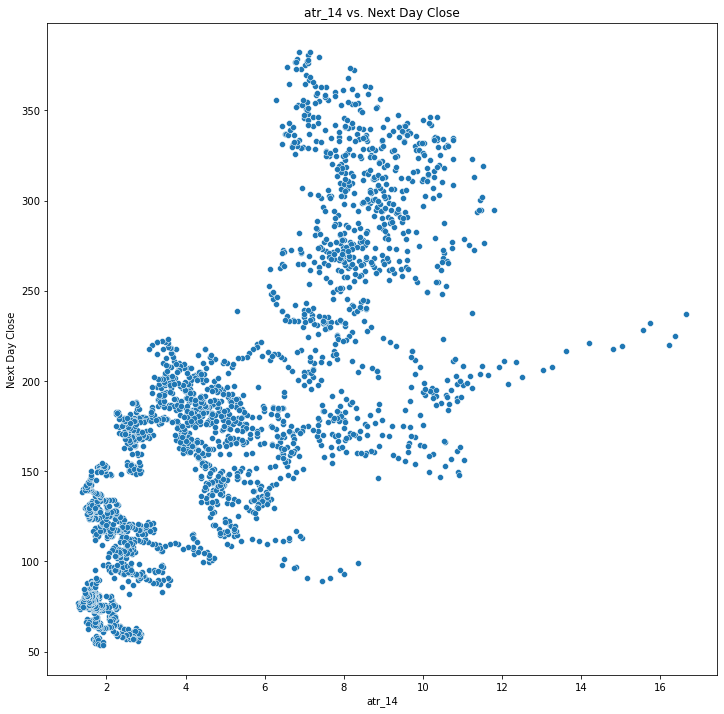

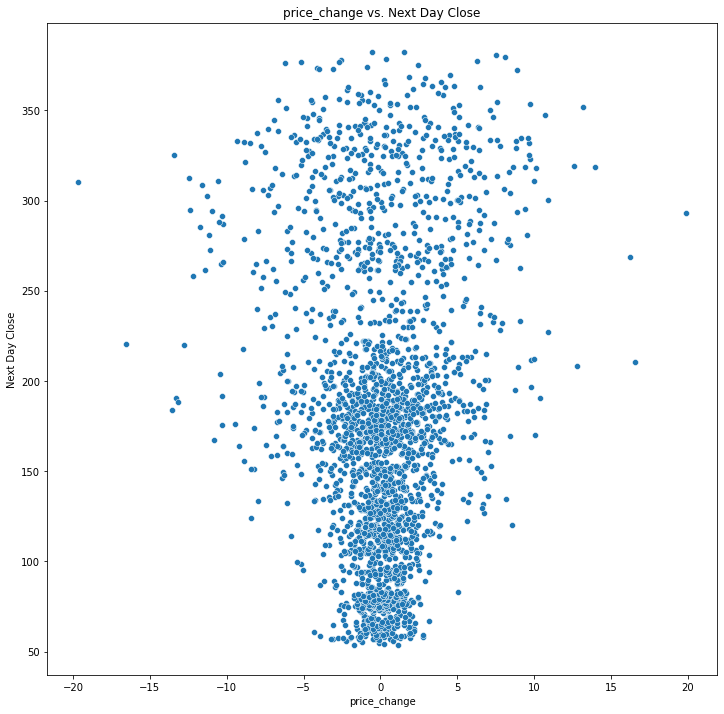

In [15]:
# Analyze and visualize the relationship between features and target (Next_Day_Close)

# Calculate the difference between Open and Close prices
data["price_change"] = data["close"] - data["open"]


# Define the specific columns you want to analyze
selected_columns = ["close", "open", "volume", "rsi_14", "atr_14", "next_day_close", "price_change"]

# Calculate correlation matrix for the selected columns
correlation = data[selected_columns].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, annot=True)
plt.title("Correlation Matrix")
plt.show()

# Scatter plots with Next_Day_Close
features_to_plot = ["close", "open", "volume", "rsi_14", "atr_14", "price_change"]  # Adjust as needed
for feature in features_to_plot:
    plt.figure(figsize=(12, 12))
    sns.scatterplot(x=feature, y="next_day_close", data=data)
    plt.title(f"{feature} vs. Next Day Close")
    plt.xlabel(feature)
    plt.ylabel("Next Day Close")
    plt.show()

# Pairplot (optional)
#sns.pairplot(data[["open", "high", "low", "volume", "rsi_7", "cci_7", "next_day_close"]])
#plt.show()  # Uncomment to display pairplot

## Why Regression Analysis?

While the correlation analysis and scatter plots provided valuable insights into potential relationships between features and the next day's closing price, they have limitations. Correlation only tells us the strength and direction of a linear relationship, not necessarily implying causation. Scatter plots offer a visual representation but can't quantify the relationships.

This is where regression analysis comes in. We'll perform a regression analysis to:

* Quantify the relationships: Regression analysis provides coefficients that indicate the magnitude and direction of the impact each feature has on the next day's closing price.
* Consider multiple features simultaneously: Unlike correlation, which analyzes features in pairs, regression can analyze how several features contribute to the target variable.
* Predict future values (with caution): Based on the fitted model, we can potentially make predictions about the next day's closing price given new data points containing the same features. However, it's important to remember that past performance is not indicative of future results, and the model's accuracy will depend on various factors.

### Significance of Regression Analysis:

By performing regression analysis, we aim to:

* Gain a more comprehensive understanding of how various features, including "atr_14" and others, influence the next day's closing price.
* Identify the most statistically significant features that have the strongest impact on the closing price. This can help us prioritize which factors to focus on for future analysis or potential trading strategies (remembering that past performance doesn't guarantee future results).
* Develop a predictive model (with caution) that can potentially estimate future closing prices based on the chosen features. This model can be used for further analysis or exploration, but it's crucial to acknowledge its limitations and potential for error.

Overall, regression analysis provides a more rigorous and quantitative approach to understanding the relationships between features and the target variable compared to correlation analysis and scatter plots alone. The results will offer valuable insights for interpreting the influence of various factors on Meta's stock price movements

In [6]:
# Define the regression formula
formula = "next_day_close ~ price_change + rsi_14 + cci_14 + atr_14"

# Create the model
model = smf.ols(formula, data=data)

# Fit the model
results = model.fit()

# Print summary statistics in a table using stargazer
#print(Stargazer([results]).render_html())
HTML(Stargazer([results]).render_html())



## Takeaways For Next Day Close 

Intercept: The intercept value (-97.029) represents the estimated next day's closing price when all other factors are equal to zero (which is not realistic in practice).

Feature coefficients:

ATR_14: A positive coefficient (23.577) with a highly significant p-value (p<0.001) suggests that higher average true range (ATR_14) is associated with a higher predicted next day's closing price.

CCI_14: A negative coefficient (-0.145) with a significant p-value (p<0.001) indicates that a higher commodity channel index (CCI_14) is associated with a slightly lower predicted next day's closing price.

Price_Change: A negative coefficient (-0.499) with a non-significant p-value (p>0.05) suggests a weak negative association between today's price change and the predicted next day's closing price. This result should be interpreted cautiously due to the lack of statistical significance.

RSI_14: A positive coefficient (2.979) with a significant p-value (p<0.001) implies that a higher relative strength index (RSI_14) is associated with a slightly higher predicted next day's closing price.

R-squared and Adjusted R-squared: The R-squared value (0.664) indicates that approximately 66.4% of the variation in the next day's closing price can be explained by the chosen features in the model. However, the adjusted R-squared (also 0.664) is a more reliable measure in this case, suggesting that the model explains 66.4% of the variance while considering the number of features included.

F-statistic and p-value: The highly significant F-statistic (1240.763 with p-value < 0.001) indicates that the overall model is statistically significant, meaning that at least one of the features has a significant relationship with the next day's closing price.

* While the model explains a notable portion of the variance in next day's closing price, it's crucial to remember that the results don't necessarily imply causality, and there might be other factors influencing the price.

* Among the chosen features, ATR_14, CCI_14, and RSI_14 show statistically significant relationships with the next day's closing price, while the relationship with price change is not statistically significant in this specific analysis.

* It's important to interpret the coefficients and p-values cautiously and consider additional factors and potential limitations before drawing definitive conclusions from this regression analysis.